In [1]:
%matplotlib inline

from eemeter.weather import ISDWeatherSource
from eemeter.location import _load_climate_zone_to_zipcodes_index
from eemeter.location import _load_zipcode_to_station_index
from eemeter.evaluation import Period
from datetime import datetime
from datetime import timedelta

import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import beta
from scipy.stats import randint
import matplotlib.pyplot as plt
import random
import json
from pkg_resources import resource_stream
from collections import defaultdict
import uuid
import os

data_dir = "/Users/philngo/Downloads/thermostats/"

In [2]:
climate_zone_zipcodes = _load_climate_zone_to_zipcodes_index()
zipcode_station = _load_zipcode_to_station_index()

climate_zones = sorted(climate_zone_zipcodes.keys())
print(climate_zones)

[u'1_A_Hot-Humid', u'2_A_Hot-Humid', u'2_A_Mixed-Humid', u'2_B_Hot-Dry', u'2_B_Hot-Humid', u'3_A_Hot-Humid', u'3_A_Mixed-Humid', u'3_B_Hot-Dry', u'4_A_Mixed-Humid', u'4_B_Cold', u'4_B_Mixed-Dry', u'4_C_Cold', u'4_C_Marine', u'5_A_Cold', u'5_B_Cold', u'6_A_Cold', u'6_B_Cold', u'7_NA_Very Cold', u'8_NA_Subarctic', u'CA_01', u'CA_02', u'CA_03', u'CA_04', u'CA_05', u'CA_06', u'CA_07', u'CA_08', u'CA_09', u'CA_10', u'CA_11', u'CA_12', u'CA_13', u'CA_14', u'CA_15', u'CA_16']


In [3]:
heating_only = [4]
cooling_only = [5]
heating_and_cooling = [1,2,3]

climate_zone_equipment_types = {
    '1_A_Hot-Humid': cooling_only,
    '2_A_Hot-Humid': cooling_only,
    '2_A_Mixed-Humid': heating_and_cooling,
    '2_B_Hot-Dry': cooling_only,
    '2_B_Hot-Humid': cooling_only,
    '3_A_Hot-Humid': cooling_only,
    '3_A_Mixed-Humid': heating_and_cooling,
    '3_B_Hot-Dry': cooling_only,
    '4_A_Mixed-Humid': heating_and_cooling,
    '4_B_Cold': heating_only,
    '4_B_Mixed-Dry': heating_and_cooling,
    '4_C_Cold': heating_only,
    '4_C_Marine': heating_and_cooling,
    '5_A_Cold': heating_and_cooling,
    '5_B_Cold': heating_only,
    '6_A_Cold': heating_and_cooling,
    '6_B_Cold': heating_only,
    '7_NA_Very Cold': heating_only,
    '8_NA_Subarctic': heating_only,
    'CA_01': heating_and_cooling,
    'CA_02': heating_and_cooling,
    'CA_03': heating_and_cooling,
    'CA_04': heating_and_cooling,
    'CA_05': heating_and_cooling,
    'CA_06': heating_and_cooling,
    'CA_07': heating_and_cooling,
    'CA_08': heating_and_cooling,
    'CA_09': heating_and_cooling,
    'CA_10': heating_and_cooling,
    'CA_11': heating_and_cooling,
    'CA_12': heating_and_cooling,
    'CA_13': heating_and_cooling,
    'CA_14': cooling_only,
    'CA_15': cooling_only,
    'CA_16': heating_and_cooling,
}

In [4]:
def get_temperatures(weather_source, start_date, n_days, utc_offset):
    all_dates, all_temps = [], []
    for days in range(n_days):
        date = start_date + timedelta(days=days) + timedelta(seconds=3600 * -utc_offset)
        period = Period(date, date + timedelta(days=1))
        temps = weather_source.hourly_temperatures(period, "degF")
        all_temps.append(temps)
        all_dates.append(date)
    return all_temps, all_dates

In [5]:
def interval_df(thermostat_id, dates, daily_temps, cooling_setpoint_10th_percentile,
                heating_setpoint_90th_percentile, scale_temps, scale_setpoints,
                heating_alpha, cooling_alpha, aux_kickin_loc, aux_kickin_scale,
                prob_missing, use_cooling=True, use_heating=True, use_aux_emerg=True):
    rows = []
    for date, temps_out in zip(dates, daily_temps):
        row = {
            "thermostat_id":thermostat_id,
            "date": date.strftime("%Y-%m-%d"),
        }
        
        heating_loc = heating_setpoint_90th_percentile - norm.ppf(.90, scale=scale_setpoints)
        cooling_loc = cooling_setpoint_10th_percentile - norm.ppf(.10, scale=scale_setpoints)
        
        heating_setpoints = norm.rvs(loc=heating_loc, scale=scale_setpoints, size=24)
        cooling_setpoints = norm.rvs(loc=cooling_loc, scale=scale_setpoints, size=24)
        
        heating_runtime = 0
        cooling_runtime = 0
        
        for i, (temp_out, heating_setpoint, cooling_setpoint) in \
                enumerate(zip(temps_out, heating_setpoints, cooling_setpoints)):
            if use_heating:    
                row["heating_setpoint_{0:02d}".format(i)] = round(heating_setpoint * 2) / 2.0
            else:
                row["heating_setpoint_{0:02d}".format(i)] = round(cooling_setpoint * 2) / 2.0
                
            if use_cooling:
                row["cooling_setpoint_{0:02d}".format(i)] = round(cooling_setpoint * 2) / 2.0
            else:
                row["cooling_setpoint_{0:02d}".format(i)] = round(heating_setpoint * 2) / 2.0
                
            if use_aux_emerg:
                row["auxiliary_heat_runtime_{0:02d}".format(i)] = 0
                row["emergency_heat_runtime_{0:02d}".format(i)] = 0
            else:
                row["auxiliary_heat_runtime_{0:02d}".format(i)] = np.nan
                row["emergency_heat_runtime_{0:02d}".format(i)] = np.nan
            
            if uniform.rvs() < prob_missing:
                row["heating_setpoint_{0:02d}".format(i)] = np.nan
            if uniform.rvs() < prob_missing:
                row["cooling_setpoint_{0:02d}".format(i)] = np.nan
        
            min_setpoint = np.min([heating_setpoint, cooling_setpoint])
            max_setpoint = np.max([heating_setpoint, cooling_setpoint])
            
            if use_heating and temp_out < min_setpoint:
                # running heating
                temp_in = norm.rvs(min_setpoint, scale_temps)
                
                # resistance_heating_runtime
                if uniform.rvs() < .997:
                    # no need for emerg_heat
                    heating = np.min([np.max([temp_in - temp_out, 0]) * heating_alpha, 3600])
                    heating_runtime += heating
                    if aux_emerg and heating > norm.rvs(aux_kickin_loc,aux_kickin_scale):
                        row["auxiliary_heat_runtime_{0:02d}".format(i)] = int(np.min([beta.rvs(.5, 5, scale=heating_runtime),3600]))
                else:
                    if aux_emerg:
                        # run emergency heat (this happens randomly sometimes)
                        row["emergency_heat_runtime_{0:02d}".format(i)] = int(np.min([beta.rvs(2, 5, scale=heating_runtime),3600]))
                    
            elif use_cooling and temp_out > max_setpoint:
                # running cooling
                temp_in = norm.rvs(max_setpoint, scale_temps)
                cooling_runtime += np.min([np.max([temp_out - temp_in, 0]) * cooling_alpha, 3600])
            else:
                # not running
                temp_in = norm.rvs(temp_out, scale_temps)

            row["temp_in_{0:02d}".format(i)] = round(temp_in * 2) / 2.0
            
            if uniform.rvs() < prob_missing:
                row["temp_in_{0:02d}".format(i)] = np.nan
                
            if uniform.rvs() < prob_missing:
                row["auxiliary_heat_runtime_{0:02d}".format(i)] = np.nan
                
            if uniform.rvs() < prob_missing:
                row["emergency_heat_runtime_{0:02d}".format(i)] = np.nan
        
        # even out heating and cooling runtimes - reduce both in proportion to amount of other.
        adjustment_proportion = (86400 - abs(heating_runtime - cooling_runtime)) / 86400
        adjustment_proportion = np.min([np.max([norm.rvs(adjustment_proportion, scale=.5),0]),1])
        
        adjustment = adjustment_proportion * np.min([heating_runtime, cooling_runtime])
        
        if use_heating:
            row["heat_runtime"] = int(heating_runtime - adjustment)
        else:
            row["heat_runtime"] = np.nan
        if use_cooling:
            row["cool_runtime"] = int(cooling_runtime - adjustment)
        else:
            row["cool_runtime"] = np.nan
        
        if uniform.rvs() < prob_missing * .1:
            row["heat_runtime"] = np.nan
        
        if uniform.rvs() < prob_missing * .1:
            row["cool_runtime"] = np.nan
            
        rows.append(row)
    return pd.DataFrame(rows)

In [6]:
def get_ct_type(ct_type):
    if ct_type == 1:
        return True, True, True
    elif ct_type == 2:
        return True, True, False
    elif ct_type == 3:
        return True, True, False
    elif ct_type == 4:
        return True, False, False
    elif ct_type == 5:
        return False, True, False
    else:
        return None

In [7]:
def export_thermostat(df, filename):
    columns = ["date", "heat_runtime", "cool_runtime"]
    
    for col in ["emergency_heat_runtime", "auxiliary_heat_runtime", \
                "heating_setpoint", "cooling_setpoint", "temp_in"]:
        for i in range(24):
            columns.append("{}_{:02d}".format(col, i))
            
    df[columns].to_csv(filename, index=False)

In [8]:
def thermostat_metadata(thermostat_ids, equipment_types, zipcodes, utc_offsets, interval_data_filenames):
    rows = []
    for thermostat_id, equipment_type, zipcode, utc_offset, interval_data_filename in \
            zip(thermostat_ids, equipment_types, zipcodes, utc_offsets, interval_data_filenames):
        rows.append({
            "thermostat_id": thermostat_id,
            "equipment_type": equipment_type,
            "zipcode": zipcode,
            "utc_offset": utc_offset,
            "interval_data_filename": interval_data_filename,
            })
    return pd.DataFrame(rows)

def export_thermostat_metadata(df, filename):
    columns = ["thermostat_id", "equipment_type", "zipcode", "utc_offset", "interval_data_filename"]
    df[columns].to_csv(filename, index=False)

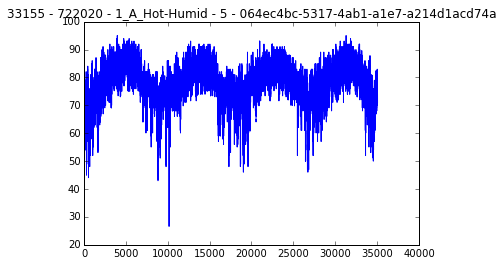

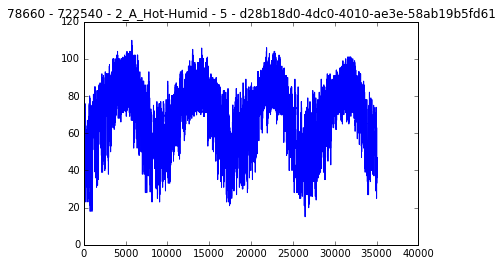

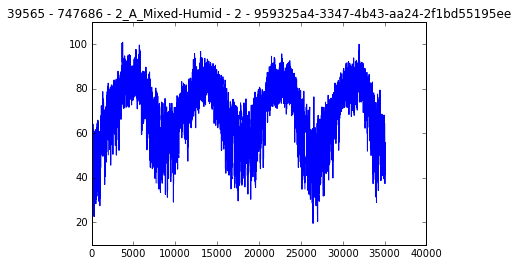

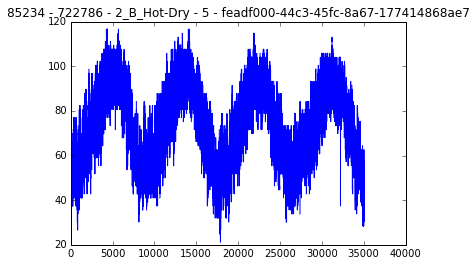

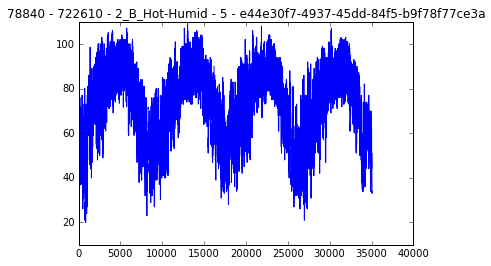

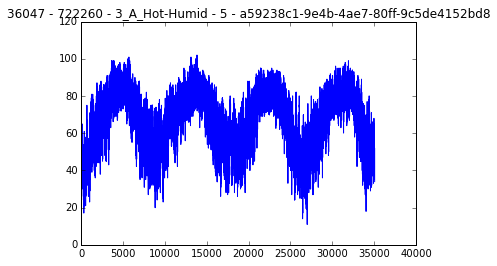

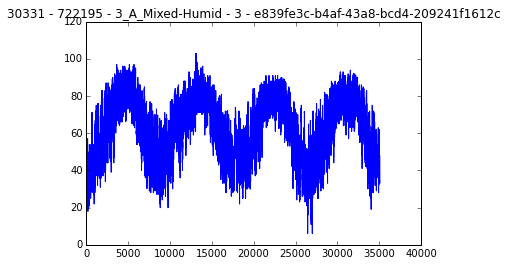

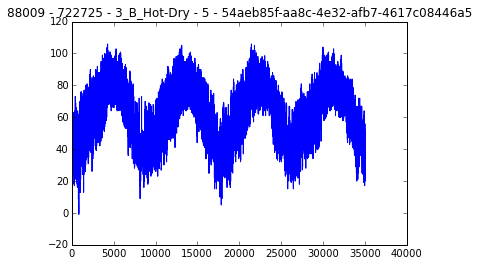

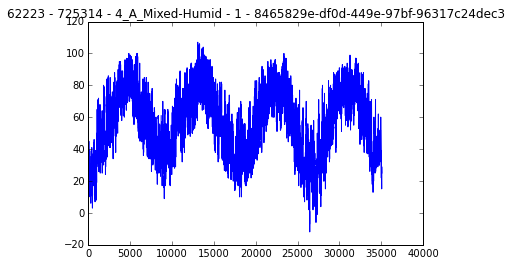

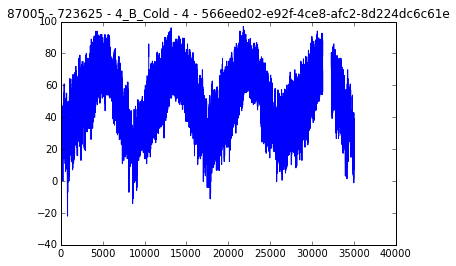

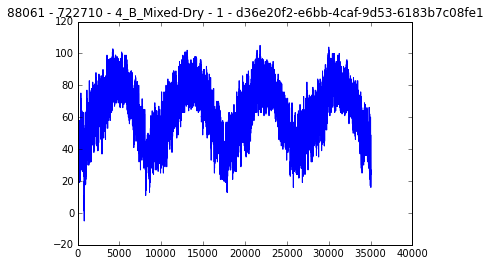

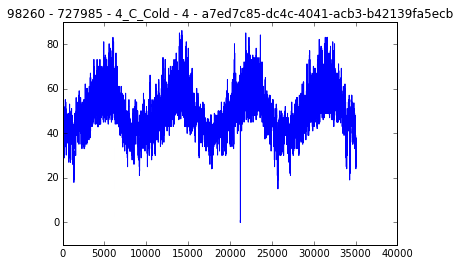

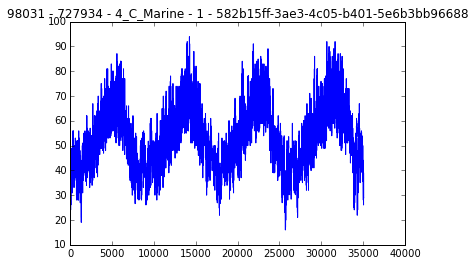

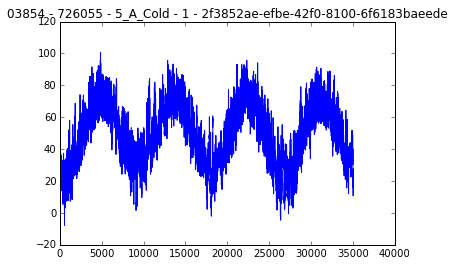

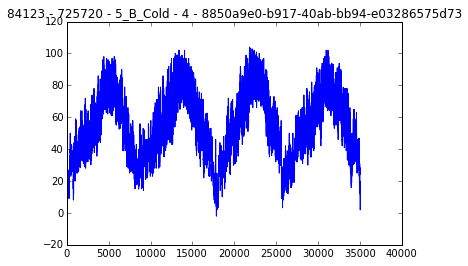

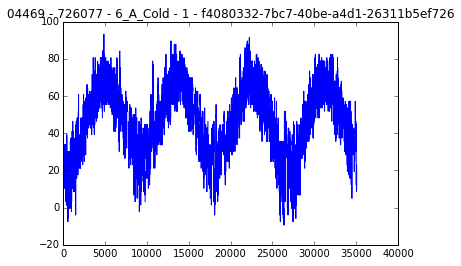

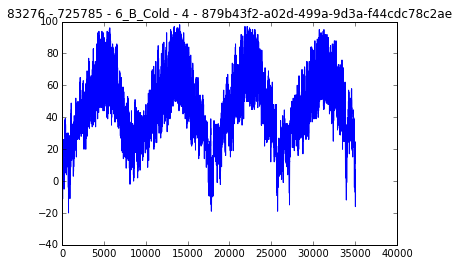

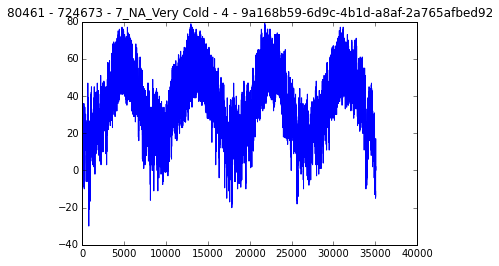

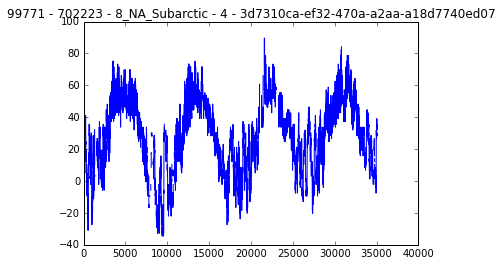

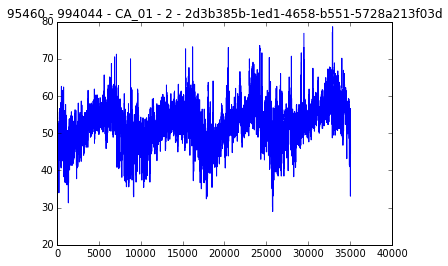

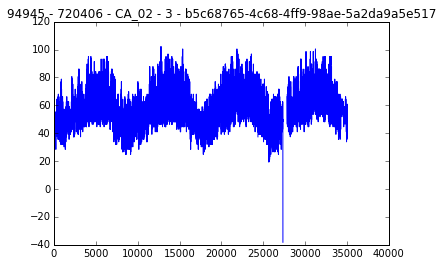

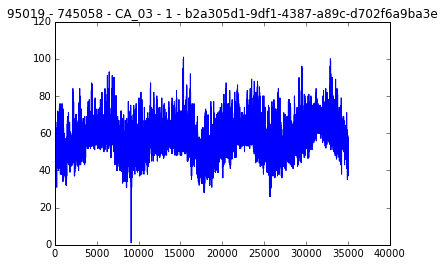

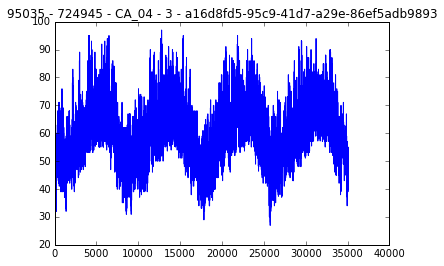

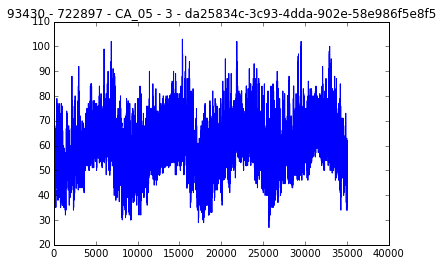

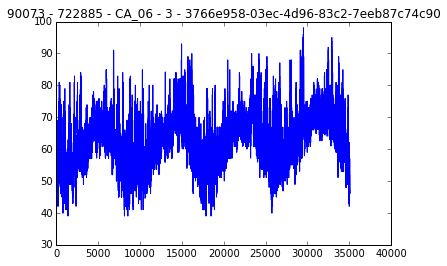

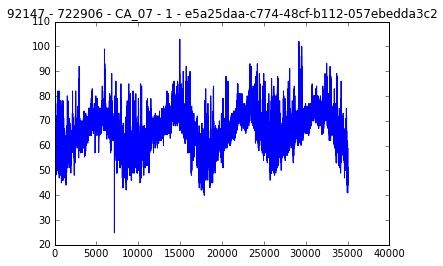

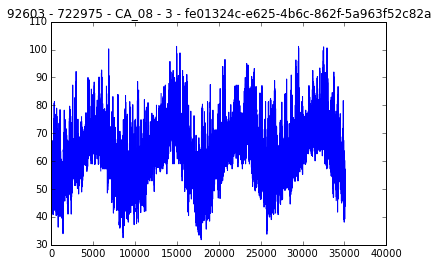

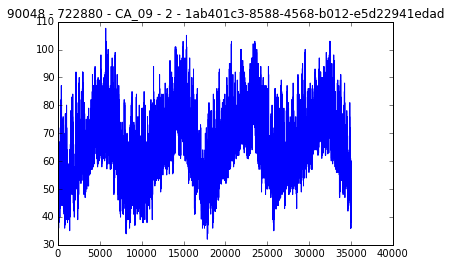

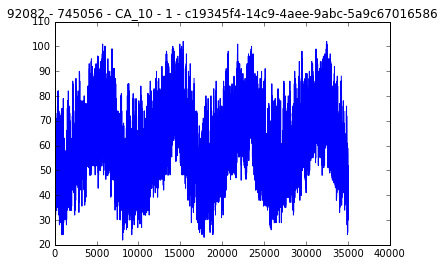

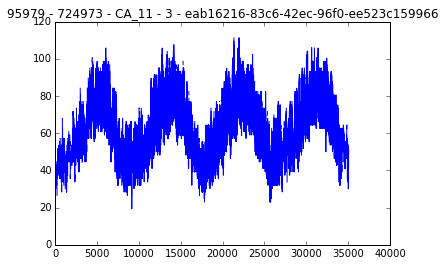

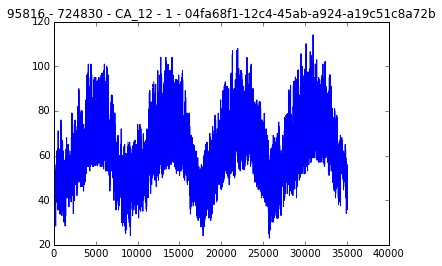

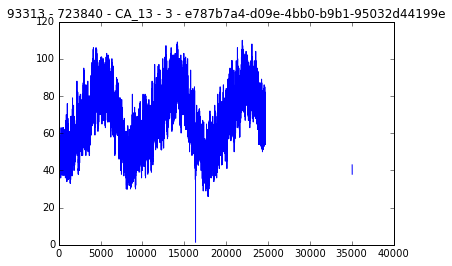

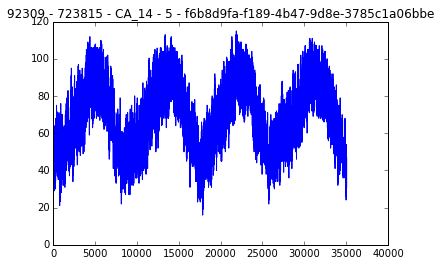

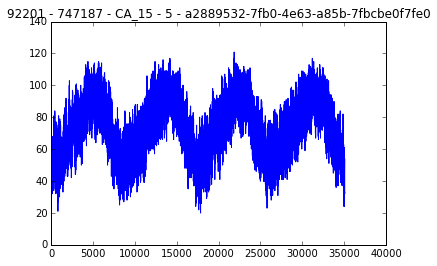

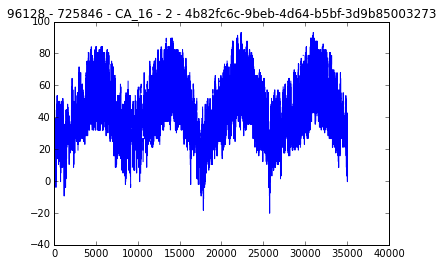

In [9]:
period = Period(datetime(2011,1,1),datetime(2015,1,1))
random.seed(1)

utc_offset = -7

scale_temps = 1
scale_setpoints = 2

start_date = datetime(2011,1,1)
n_days = 365 * 4 + 1

zipcodes, stations, weather_sources = [], [], []
dfs, utc_offsets, thermostat_ids = [], [], []
ct_types = []
filenames = []

for climate_zone in climate_zones:
    
    ct_type = random.choice(climate_zone_equipment_types[climate_zone])
    ct_types.append(ct_type)
    
    zipcode = random.choice(climate_zone_zipcodes[climate_zone])
    zipcodes.append(zipcode)
    
    station = zipcode_station[zipcode]
    stations.append(station)
    
    weather_source = ISDWeatherSource(station, 2011, 2015)
    weather_sources.append(weather_source)
    
    thermostat_id = uuid.uuid4()
    thermostat_ids.append(thermostat_id)
    
    utc_offsets.append(utc_offset)
    
    # additional parameters
    cooling_setpoint_10th_percentile = norm.rvs(73,1)
    heating_setpoint_90th_percentile = norm.rvs(68,1)
    heating_alpha = norm.rvs(100,20)
    cooling_alpha = norm.rvs(100,20)
    aux_kickin_loc = norm.rvs(3600,1000)
    aux_kickin_scale = norm.rvs(900,100)
    prob_missing = beta.rvs(2,20)
    heating, cooling, aux_emerg = get_ct_type(ct_type)
    
    temps, dates = get_temperatures(weather_source, start_date, n_days, utc_offset)
    
    # get dataframe
    df = interval_df(thermostat_id, dates, temps, cooling_setpoint_10th_percentile,
                     heating_setpoint_90th_percentile, scale_temps, scale_setpoints,
                     heating_alpha, cooling_alpha, aux_kickin_loc, aux_kickin_scale,
                     prob_missing, use_heating=heating, use_cooling=cooling, use_aux_emerg=aux_emerg)
    dfs.append(df)
    
    plt.plot(np.array(temps).flatten())
    plt.title("{} - {} - {} - {} - {}".format(zipcode, station, climate_zone, ct_type, thermostat_id))
    plt.show()
    
    filename = "thermostat_{}.csv".format(thermostat_id)
    filenames.append(filename)
    path = os.path.join(data_dir, filename)
    export_thermostat(df, path)
    

In [10]:
metadata_df = thermostat_metadata(thermostat_ids, ct_types, zipcodes, utc_offsets, filenames)

In [11]:
export_thermostat_metadata(metadata_df, os.path.join(data_dir, "metadata.csv"))